### Analysis of Yelp data result

In [12]:
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline

In [13]:
!ls -alt *.pkl

-rw-r--r-- 1 root root  3343534 Mar  7 06:34 MNARxMARyelp_log35_28.pkl
-rw-r--r-- 1 root root  3488134 Mar  7 06:31 MNARxMARyelp_log35_25.pkl
-rw-r--r-- 1 root root  3632134 Mar  7 06:05 MNARxMARyelp_log35_22.pkl
-rw-r--r-- 1 root root  3776134 Mar  7 03:52 MNARxMARyelp_log35_19.pkl
-rw-r--r-- 1 root root   168342 Mar  5 10:10 MARyelp_log35_25.pkl
-rw-r--r-- 1 root root   264342 Mar  5 10:10 MARyelp_log35_22.pkl
-rw-r--r-- 1 root root   360342 Mar  5 10:09 MARyelp_log35_19.pkl
-rw-r--r-- 1 root root    71942 Mar  5 10:09 MARyelp_log35_28.pkl
-rw-r--r-- 1 1004 1004    53960 Feb 14 16:52 MNARyelp_linear.pkl
-rw-r--r-- 1 1004 1004    53960 Feb 12 12:47 MARyelp_linear.pkl
-rw-rw-r-- 1 1004 1004    80160 Feb 11 09:27 Ymat.pkl
-rw-rw-r-- 1 1004 1004 41600163 Feb 11 09:27 Xsps.pkl
-rw-rw-r-- 1 1004 1004  2080162 Feb 11 09:27 Xmat.pkl


In [14]:
MARress = []
MNARress = []

In [15]:
with open("./MNARxMARyelp_log35_28.pkl", "rb") as f:
    MNARxMAR28 = pickle.load(f)
MARress.append(MNARxMAR28["MARres"])
MNARress.append(MNARxMAR28["MNARres"])

In [16]:
with open("./MARyelp_log35_25.pkl", "rb") as f:
    MARres = pickle.load(f)
with open("./MNARxMARyelp_log35_25.pkl", "rb") as f:
    MNARxMAR25 = pickle.load(f)

#MARress.append(MARres)
MARress.append(MNARxMAR25["MARres"])
MNARress.append(MNARxMAR25["MNARres"])

In [17]:
with open("./MNARxMARyelp_log35_22.pkl", "rb") as f:
    MNARxMAR22 = pickle.load(f)

MARress.append(MNARxMAR22["MARres"])
MNARress.append(MNARxMAR22["MNARres"])

In [18]:
with open("./MNARxMARyelp_log35_19.pkl", "rb") as f:
    MNARxMAR19 = pickle.load(f)

MARress.append(MNARxMAR19["MARres"])
MNARress.append(MNARxMAR19["MNARres"])

In [19]:
def AUCplot(MARres, MNARres, i, is_plot=False):
    marres,  mnarres = MARres[i], MNARres[i]
    marprobs, margts = marres[0].cpu().numpy(), marres[1].cpu().numpy()
    mnarprobs, mnargts = mnarres[0].cpu().numpy(), mnarres[1].cpu().numpy()
    marfpr, martpr, marthre = metrics.roc_curve(margts, marprobs)
    mnarfpr, mnartpr, mnarthre = metrics.roc_curve(mnargts, mnarprobs)
    marauc = metrics.roc_auc_score(margts, marprobs)
    mnarauc = metrics.roc_auc_score(mnargts, mnarprobs)
    if is_plot:
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(marfpr, martpr, "--r", label="MAR")
        plt.plot(mnarfpr, mnartpr, label="MNAR")
        plt.legend()
    return marauc, mnarauc
    

In [20]:
allaucdfs = []

In [21]:
for MARres, MNARres in zip(MARress, MNARress):
    allaucs = [AUCplot(MARres, MNARres, i)  for i in range(1, 21)] 
    allaucs = np.array(allaucs)
    allaucdf = pd.DataFrame(allaucs)
    allaucdf.columns = ["MAR", "MNAR"]
    allaucdfs.append(allaucdf)

## Handle data in a single missing rate

In [38]:
MNARres, MARres = MNARress[0], MARress[0]
MARprobs = []
MARgt = []
MNARprobs = []
MNARgt = []
for i in range(1, len(MNARres)+1):
    mnarres = MNARres[i]
    MNARprobs.append(mnarres[0].cpu().numpy())
    MNARgt.append(mnarres[1].cpu().numpy())
for i in range(1, len(MARres)+1):
    marres = MARres[i]
    MARprobs.append(marres[0].cpu().numpy())
    MARgt.append(marres[1].cpu().numpy())

In [39]:
MARgt = np.concatenate(MARgt)
MNARgt = np.concatenate(MNARgt)
MARprobs = np.concatenate(MARprobs)
MNARprobs = np.concatenate(MNARprobs)

In [40]:
Data = {
    "Probs": np.concatenate([MNARprobs, MARprobs]),
    "Method": ["MNAR"] * len(MNARprobs) + ["MAR"] * len(MARprobs),
    "GT": np.concatenate([MNARgt, MARgt])
}
dfdata = pd.DataFrame(Data)

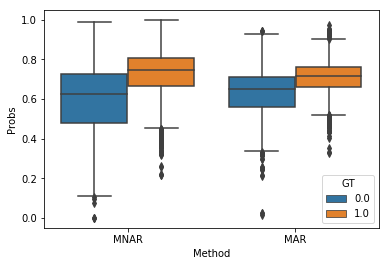

In [41]:
sns.boxplot(data=dfdata, x="Method", y="Probs", hue="GT")

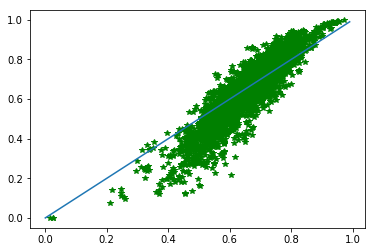

In [42]:
#plt.plot(MARgt[:200], "bo")
#plt.plot(MARgt[:200], MARprobs[:200], "rh")
#plt.plot(MARgt[:200], MNARprobs[:200], "g*")
plt.plot(MARprobs[:], MNARprobs[:], "g*")
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))

In [43]:
dfdatagrp = dfdata.groupby(["Method", "GT"])

In [44]:
dfdatagrp.describe()

Probs                                                    \
             count      mean       std       min       25%       50%   
Method GT                                                              
MAR    0.0  1860.0  0.633426  0.106887  0.016876  0.561936  0.648620   
       1.0  1860.0  0.705627  0.085787  0.329229  0.663502  0.714578   
MNAR   0.0  1860.0  0.598231  0.165609  0.000378  0.479674  0.623685   
       1.0  1860.0  0.726287  0.124004  0.217999  0.664266  0.744660   

                                
                 75%       max  
Method GT                       
MAR    0.0  0.712443  0.945278  
       1.0  0.759696  0.972571  
MNAR   0.0  0.724833  0.986515  
       1.0  0.806898  0.997841

In [45]:
from sklearn import metrics

In [46]:
metrics.roc_auc_score(MARgt, MARprobs)

0.7005616256214591

In [47]:
metrics.roc_auc_score(MNARgt, MNARprobs)

0.7315363047751186

In [48]:
marfpr, martpr, marthre = metrics.roc_curve(MARgt, MARprobs)
mnarfpr, mnartpr, mnarthre = metrics.roc_curve(MNARgt, MNARprobs)

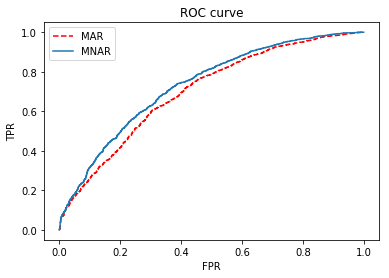

In [49]:
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(marfpr, martpr, "--r", label="MAR")
plt.plot(mnarfpr, mnartpr, label="MNAR")
plt.legend()

## Plot the figures in paper

In [22]:
diffs = []
CIs = []
qCIs = []
mdiffs = []
for allaucdf in allaucdfs:
    marres = np.array(allaucdf["MAR"])
    mnarres = np.array(allaucdf["MNAR"])
    diff = mnarres - marres
    print(np.mean(mnarres), np.mean(marres))
    mdiffs.append(np.mean(diff))
    diffs.append(diff)
    qCIs.append([np.quantile(diff, 0.025), np.quantile(diff, 0.975)])
    CIs.append([np.mean(diff) - 1.96* np.std(diff)/np.sqrt(len(diff)), np.mean(diff) + 1.96* np.std(diff)/np.sqrt(len(diff))])

0.7326627355763673 0.701358538559371
0.7213764082844227 0.6822994670444581
0.7149536301520258 0.6664868059053746
0.6984110944101399 0.6289296934243311


In [23]:
CIs = np.array(CIs)
qCIs = np.array(qCIs)
diffs = np.array(diffs)
mdiffs = np.array(mdiffs)

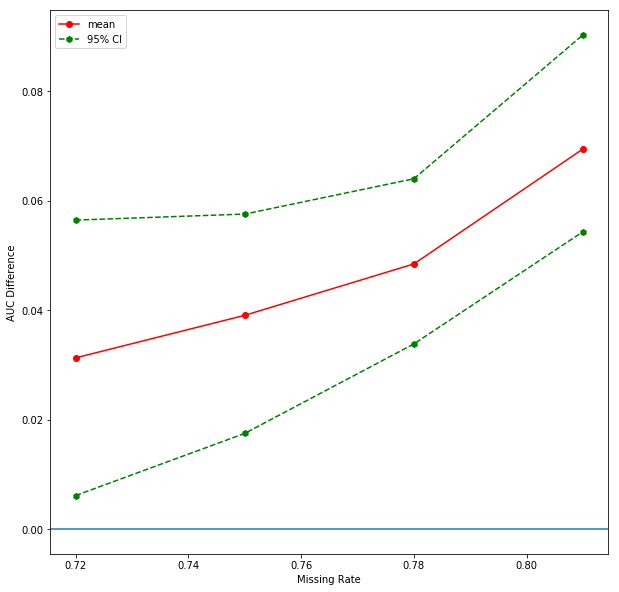

In [24]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel("Missing Rate")
plt.ylabel("AUC Difference")
plt.plot([0.72, 0.75, 0.78, 0.81], mdiffs, "r-o", label="mean")
plt.plot([0.72, 0.75, 0.78, 0.81], qCIs[:, 0], "g--h", label="95% CI")
plt.plot([0.72, 0.75, 0.78, 0.81], qCIs[:, 1], "g--h")
plt.axhline(0)
plt.legend()

In [25]:
diffs

array([[0.02115852, 0.00416233, 0.02890508, 0.03006128, 0.04601688,
        0.02428026, 0.01907735, 0.02011793, 0.03214244, 0.01942421,
        0.05757891, 0.05422592, 0.03676726, 0.00832466, 0.01456816,
        0.05341658, 0.0552665 , 0.04520754, 0.02023355, 0.03514857],
       [0.01084463, 0.02636106, 0.05555556, 0.04573973, 0.0594178 ,
        0.042316  , 0.0348951 , 0.04567227, 0.03853808, 0.02484315,
        0.04290629, 0.04472779, 0.02545031, 0.03848749, 0.04132092,
        0.04987182, 0.03821763, 0.04353032, 0.03263509, 0.04020779],
       [0.0351003 , 0.03920125, 0.06750752, 0.04594361, 0.04802315,
        0.0417587 , 0.04660234, 0.05422301, 0.04870126, 0.04241097,
        0.04930833, 0.04802315, 0.03271722, 0.04662818, 0.04794565,
        0.06019685, 0.05152995, 0.05308637, 0.05408093, 0.05634776],
       [0.05809907, 0.05508274, 0.08724339, 0.05742539, 0.05613219,
        0.08139692, 0.05409084, 0.07902381, 0.05890816, 0.07006283,
        0.08044565, 0.07138988, 0.07160993, 0

Text(0.04, 0.5, 'AUC Difference')

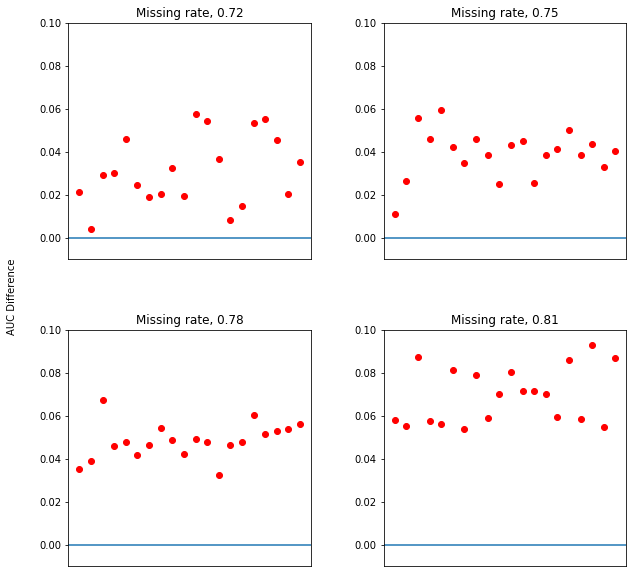

In [26]:
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(221)
plt.title("Missing rate, 0.72")
plt.xticks([])
plt.ylim([-0.01, 0.1])
plt.plot(diffs[0], "or")
plt.axhline(0)

plt.subplot(222)
plt.title("Missing rate, 0.75")
plt.plot(diffs[1], "or")
plt.xticks([])
plt.ylim([-0.01, 0.1])
plt.axhline(0)

plt.subplot(223)
plt.title("Missing rate, 0.78")
plt.plot(diffs[2], "or")
plt.xticks([])
plt.ylim([-0.01, 0.1])
plt.axhline(0)

plt.subplot(224)
plt.title("Missing rate, 0.81")
plt.plot(diffs[3], "or")
plt.xticks([])
plt.ylim([-0.01, 0.1])
plt.axhline(0)

#fig.text(0.5, 0.04, 'common X', ha='center')
fig.text(0.04, 0.5, 'AUC Difference', va='center', rotation='vertical')

In [16]:
qCIs

array([[0.00766563, 0.05729275],
       [0.01705837, 0.05703257],
       [0.0331785 , 0.06348794],
       [0.05487945, 0.08969285]])

In [17]:
CIs

array([[0.02382607, 0.03773018],
       [0.03363278, 0.0429644 ],
       [0.04447665, 0.05147277],
       [0.06402994, 0.07500802]])

## Save the result in numpy form

In [42]:
SAVEDMARress = {}
for MARres, MR in zip(MARress, [0.72, 0.75, 0.78, 0.81]):
    res = []
    for i in range(1, 21):
        res.append([MARres[i][0].cpu().numpy(), MARres[i][1].cpu().numpy()])
    SAVEDMARress[MR] = res
    

In [43]:
SAVEDMNARress = {}
for MNARres, MR in zip(MNARress, [0.72, 0.75, 0.78, 0.81]):
    res = []
    for i in range(1, 21):
        res.append([MNARres[i][0].cpu().numpy(), MNARres[i][1].cpu().numpy()])
    SAVEDMNARress[MR] = res

In [61]:

paras72beta = {"MNAR": [], "MAR":[]}
paras72theta = {"MNAR": [], "MAR":[]}
paras75beta = {"MNAR": [], "MAR":[]}
paras75theta = {"MNAR": [], "MAR":[]}
paras78beta = {"MNAR": [], "MAR":[]}
paras78theta = {"MNAR": [], "MAR":[]}
paras81beta = {"MNAR": [], "MAR":[]}
paras81theta = {"MNAR": [], "MAR":[]}
for i in range(20):
    paras72beta["MNAR"].append(MNARxMAR28["paras"]["MNAR"][i]["beta"].cpu().numpy())
    paras72theta["MNAR"].append(MNARxMAR28["paras"]["MNAR"][i]["theta"].cpu().numpy())
    paras72beta["MAR"].append(MNARxMAR28["paras"]["MAR"][i]["beta"].cpu().numpy())
    paras72theta["MAR"].append(MNARxMAR28["paras"]["MAR"][i]["theta"].cpu().numpy())
    
    paras75beta["MNAR"].append(MNARxMAR25["paras"]["MNAR"][i]["beta"].cpu().numpy())
    paras75theta["MNAR"].append(MNARxMAR25["paras"]["MNAR"][i]["theta"].cpu().numpy())
    paras75beta["MAR"].append(MNARxMAR25["paras"]["MAR"][i]["beta"].cpu().numpy())
    paras75theta["MAR"].append(MNARxMAR25["paras"]["MAR"][i]["theta"].cpu().numpy())
    
    paras78beta["MNAR"].append(MNARxMAR22["paras"]["MNAR"][i]["beta"].cpu().numpy())
    paras78theta["MNAR"].append(MNARxMAR22["paras"]["MNAR"][i]["theta"].cpu().numpy())
    paras78beta["MAR"].append(MNARxMAR22["paras"]["MAR"][i]["beta"].cpu().numpy())
    paras78theta["MAR"].append(MNARxMAR22["paras"]["MAR"][i]["theta"].cpu().numpy())
    
    paras81beta["MNAR"].append(MNARxMAR19["paras"]["MNAR"][i]["beta"].cpu().numpy())
    paras81theta["MNAR"].append(MNARxMAR19["paras"]["MNAR"][i]["theta"].cpu().numpy())
    paras81beta["MAR"].append(MNARxMAR19["paras"]["MAR"][i]["beta"].cpu().numpy())
    paras81theta["MAR"].append(MNARxMAR19["paras"]["MAR"][i]["theta"].cpu().numpy())

In [62]:
SAVEDparas = {
    0.72: [paras72beta, paras72theta],
    0.75: [paras75beta, paras75theta],
    0.78: [paras78beta, paras78theta],
    0.81: [paras81beta, paras81theta],
}

In [64]:
with open("paras.pkl", "wb") as f:
    pickle.dump(SAVEDparas, f)

In [65]:
with open("MNARresfinal.pkl", "wb") as f:
    pickle.dump(SAVEDMNARress, f)

In [66]:
with open("MARresfinal.pkl", "wb") as f:
    pickle.dump(SAVEDMARress, f)